# kaggle score: 83.45 % AUC - Gradient Boost Model - after downsampling

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt       
%matplotlib inline 
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import RandomizedSearchCV
import json
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import randint as sp_randint
from sklearn.metrics import classification_report,confusion_matrix
from collections import Counter

In [6]:
train=pd.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv')
train.shape

(76020, 371)

In [7]:
test=pd.read_csv('/content/drive/My Drive/Colab Notebooks/test.csv')
test.shape

(75818, 370)

In [8]:
with open("/content/drive/My Drive/Colab Notebooks/final_lr_features.txt", "r") as fp:
  lr_feats = json.load(fp)

with open("/content/drive/My Drive/Colab Notebooks/final_rf_features.txt", "r") as fp:
  rf_feats = json.load(fp)

with open("/content/drive/My Drive/Colab Notebooks/final_gb_features.txt", "r") as fp:
  gb_feats = json.load(fp)

**lets club all the selected features**

In [9]:
feature_set = list(set(lr_feats + rf_feats + gb_feats))
len(feature_set)

27

**This is how the target distribution looks like right now:**

0    0.960431
1    0.039569
Name: TARGET, dtype: float64
0    73012
1     3008
Name: TARGET, dtype: int64


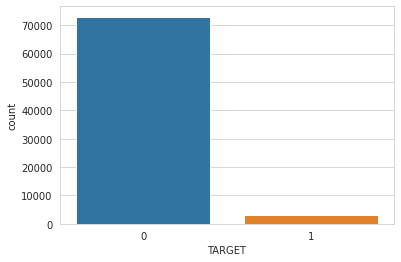

In [10]:
sns.countplot(x="TARGET",data=train)
print(train["TARGET"].value_counts(normalize=True))
print(train["TARGET"].value_counts())

In [11]:
y = train["TARGET"]
train = train.drop(["ID"], axis=1) 

**Plotting scatter plot between top 50 pairs**

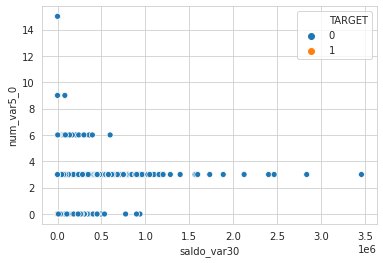

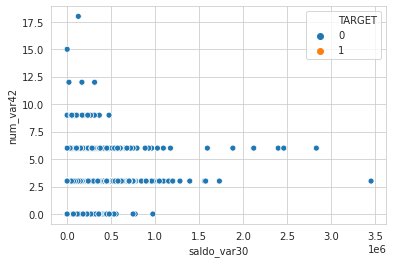

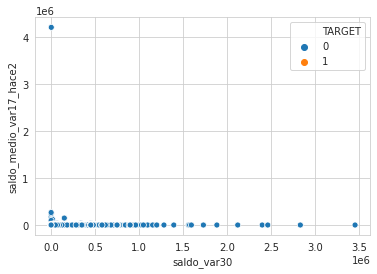

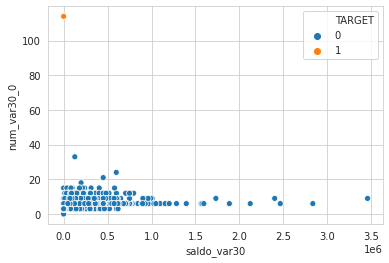

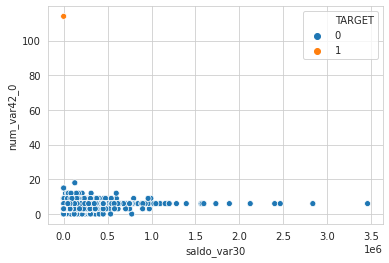

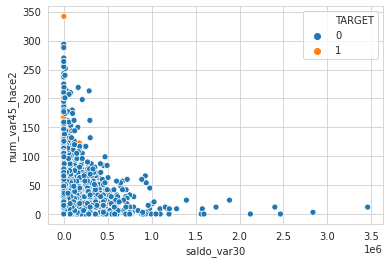

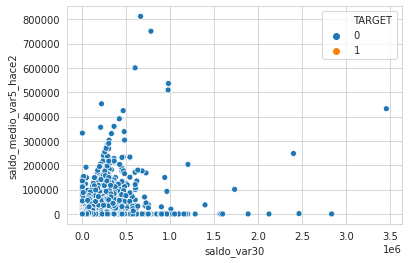

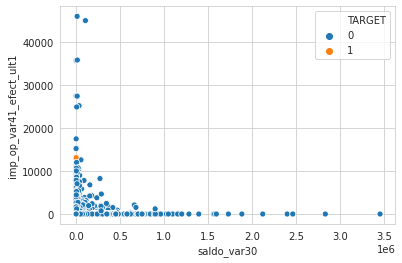

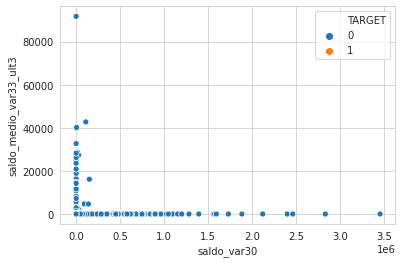

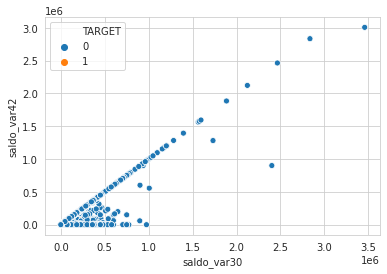

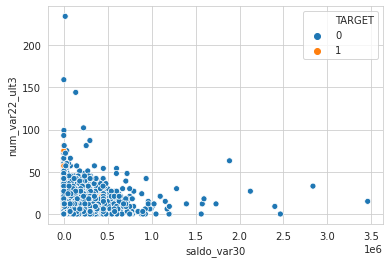

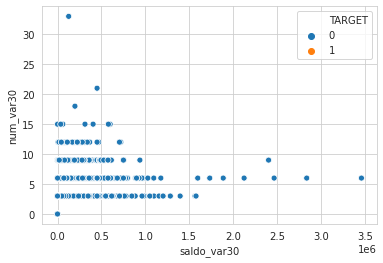

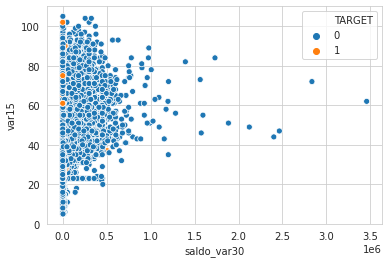

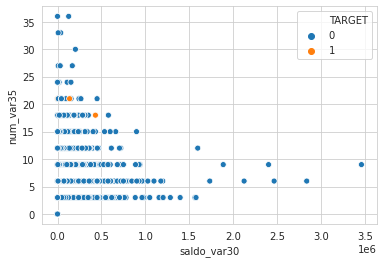

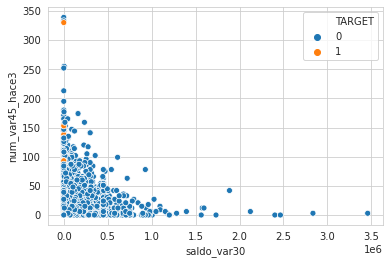

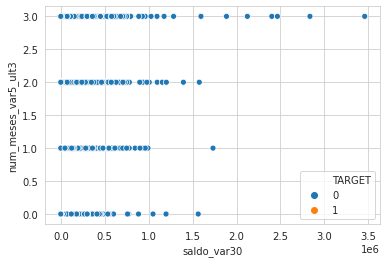

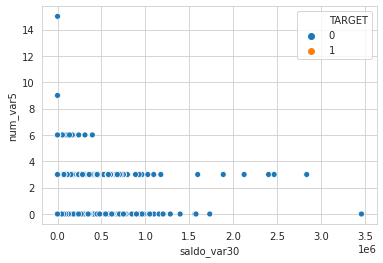

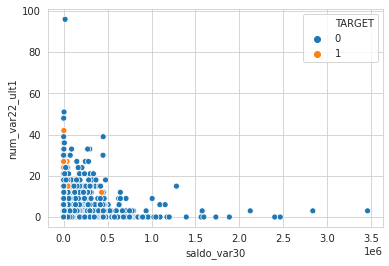

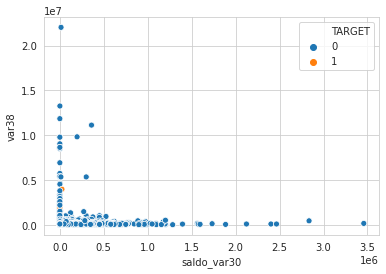

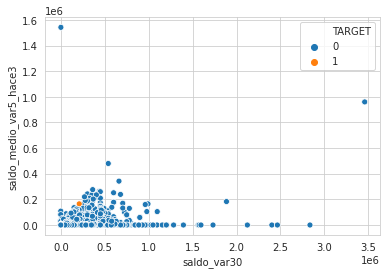

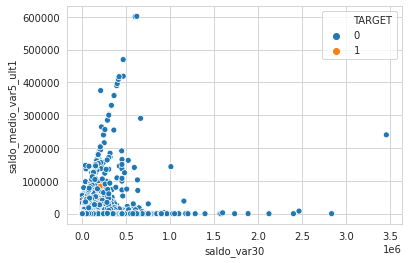

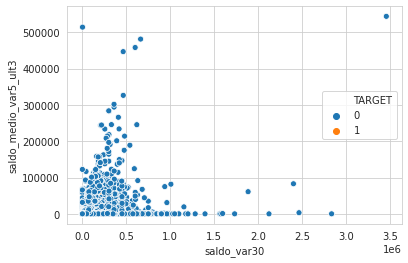

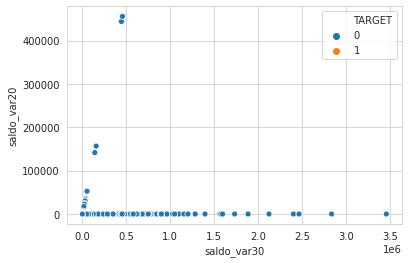

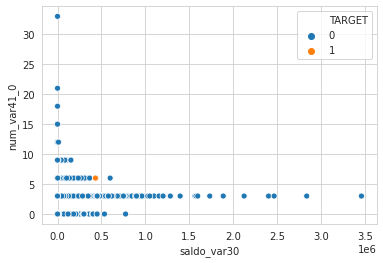

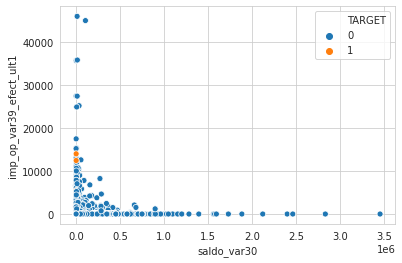

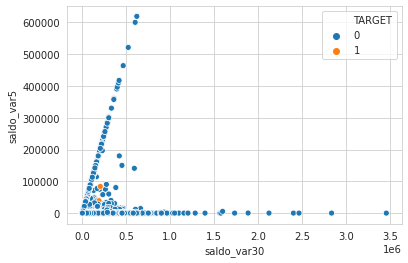

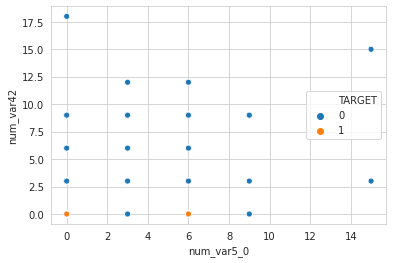

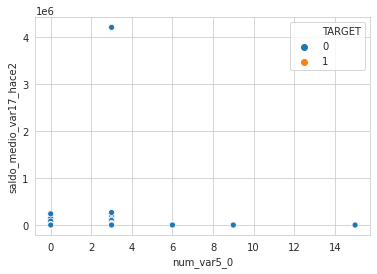

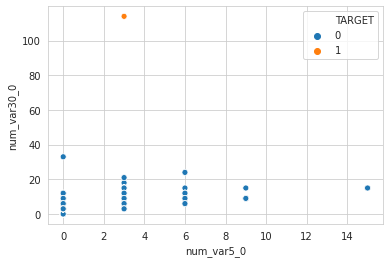

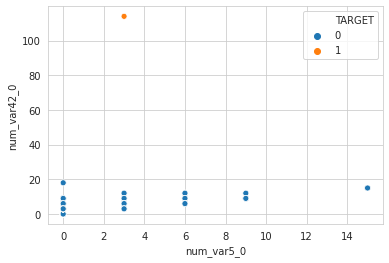

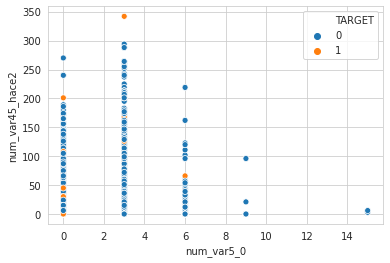

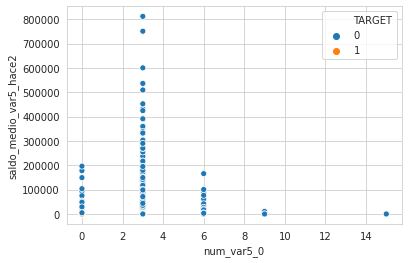

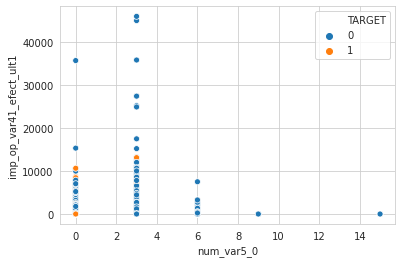

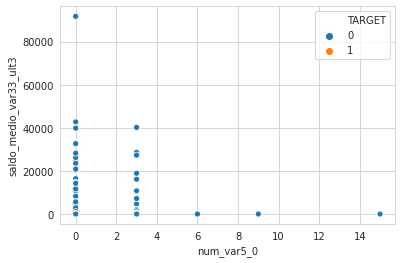

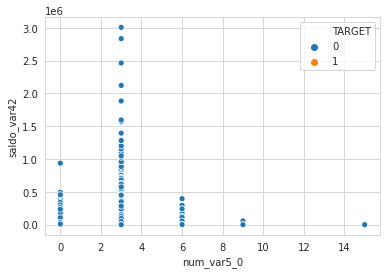

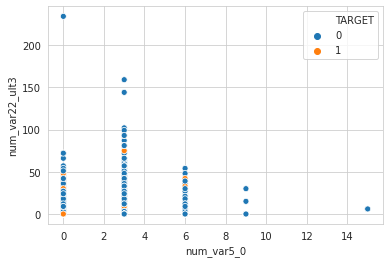

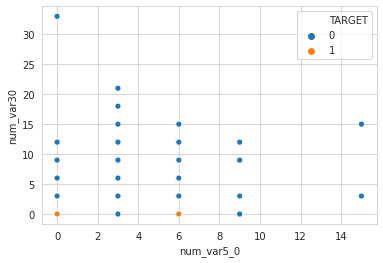

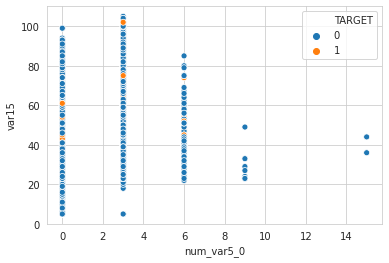

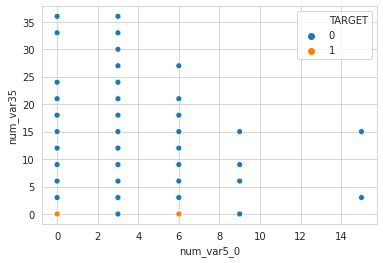

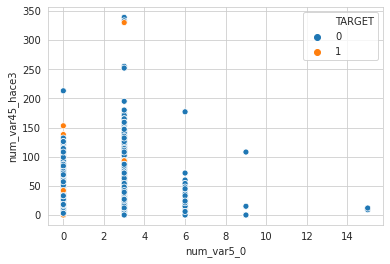

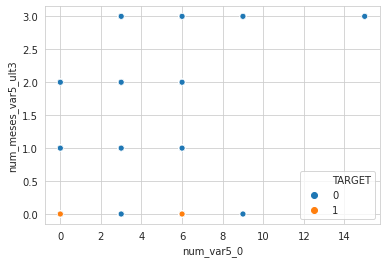

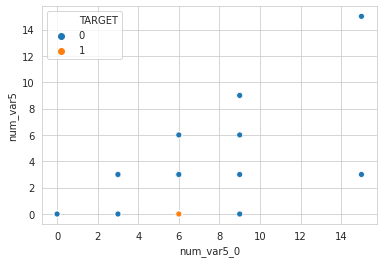

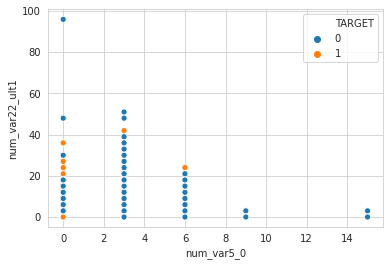

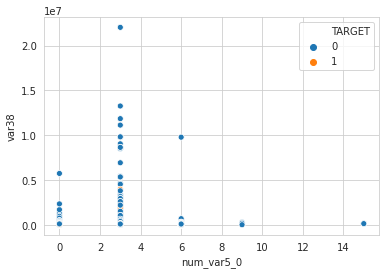

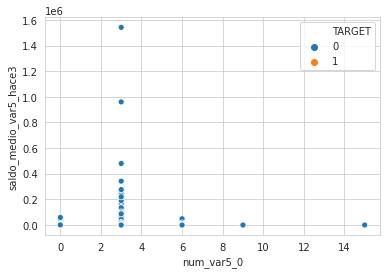

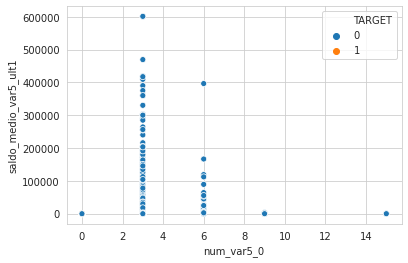

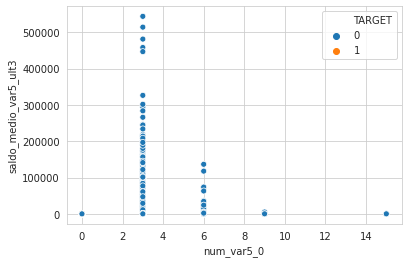

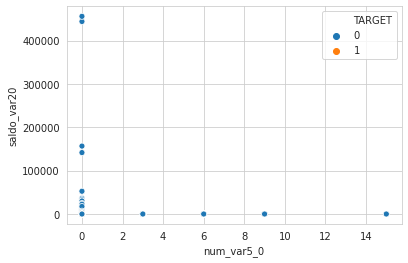

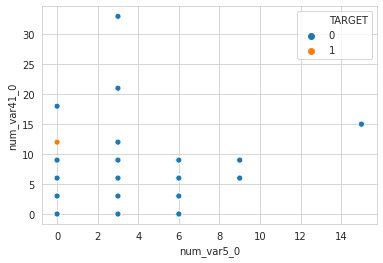

In [40]:
from itertools import combinations

count=1
for i,j in combinations(feature_set,2):
    if(count==50):
      break;

    plt.figure(count)
    sns.scatterplot(x=i,y=j,data=train,hue="TARGET")
    count=count+1

In [12]:
train=train[feature_set]
print(train.shape)

(76020, 27)


**Due to a highly imbalanced dataset we saw in the previous part that we were not really able to predict the minority class. Not only that due to a huge number of records the training and tuning took a lot of time. <br>In this part we will down sample the majority class. This will help us in predicting the minority class better and will also decrease the training and tuning time and efforts.**

In [13]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy=0.4,random_state=7,replacement=True)
x_down, y_down = undersample.fit_resample(X=train,y=y)
x_down = pd.DataFrame(x_down)
x_down.columns = feature_set

print(Counter(y))
print(Counter(y_down))

x_down["TARGET"] = y_down

Counter({0: 73012, 1: 3008})
Counter({0: 7520, 1: 3008})


**This is how the target distribution looks like now:**

0    0.714286
1    0.285714
Name: TARGET, dtype: float64
0    7520
1    3008
Name: TARGET, dtype: int64


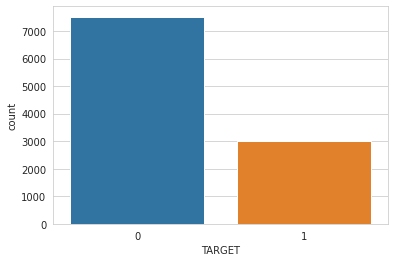

In [14]:
sns.countplot(x="TARGET",data=x_down)
print(x_down["TARGET"].value_counts(normalize=True))
print(x_down["TARGET"].value_counts())

**Lets plot the same pairs again:**

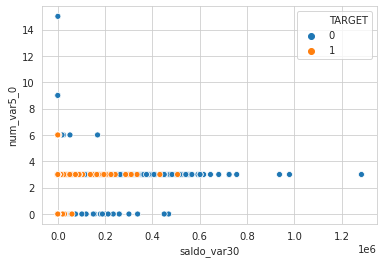

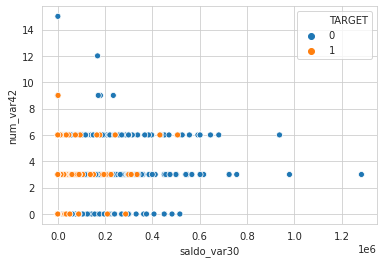

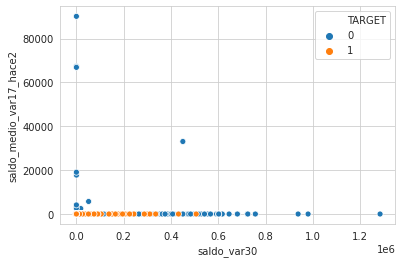

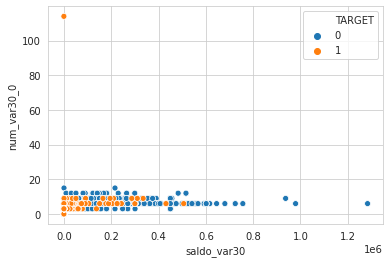

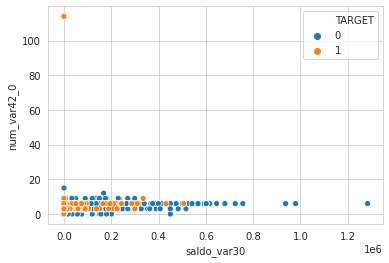

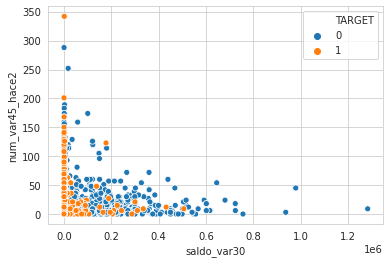

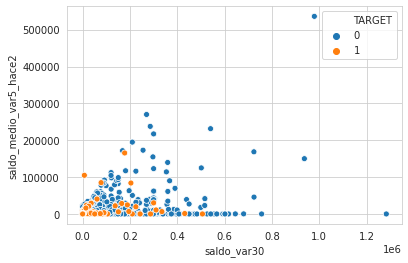

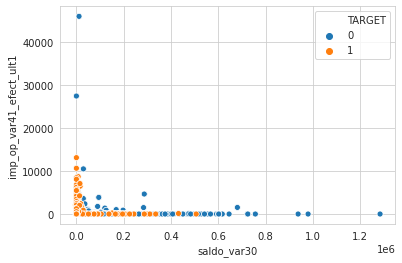

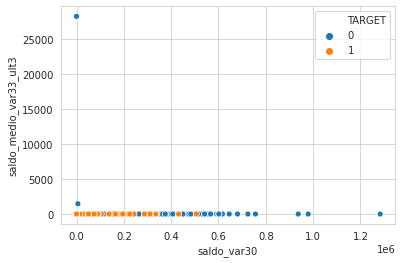

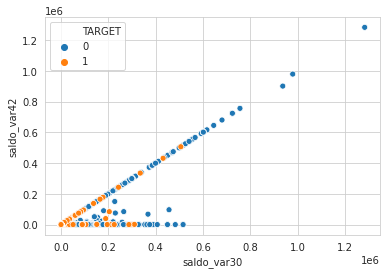

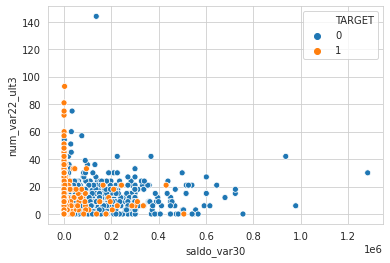

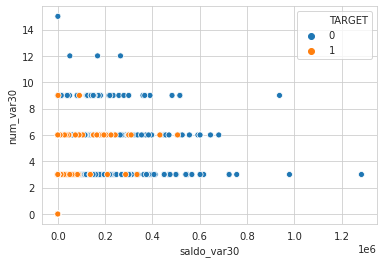

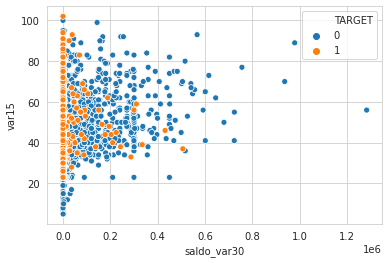

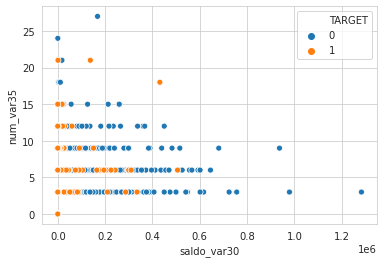

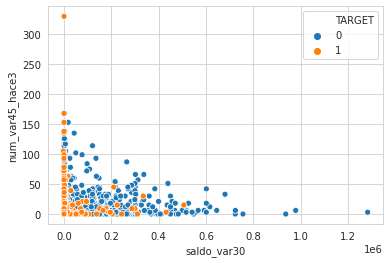

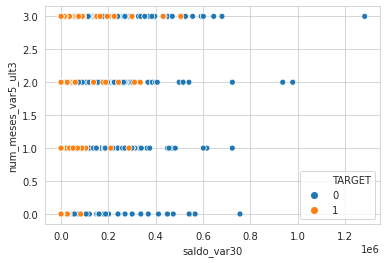

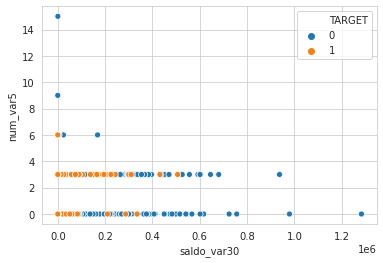

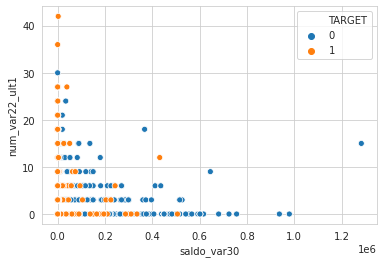

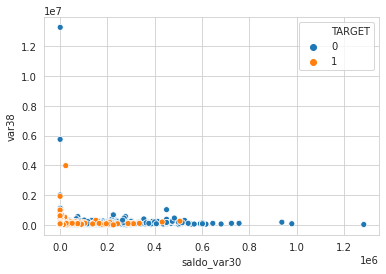

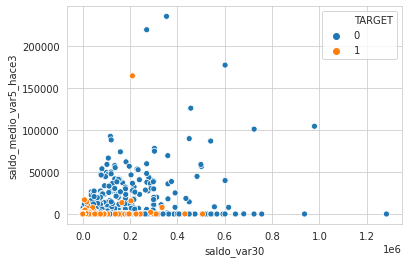

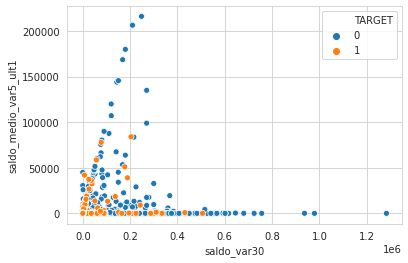

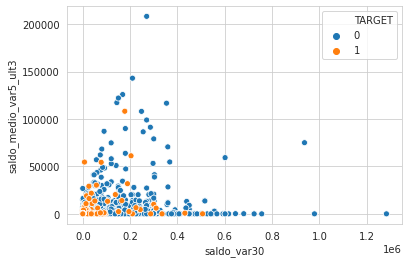

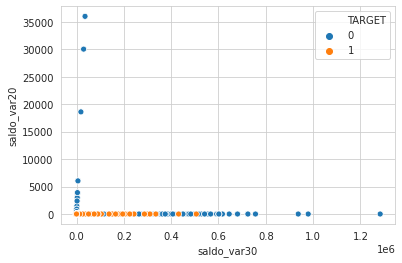

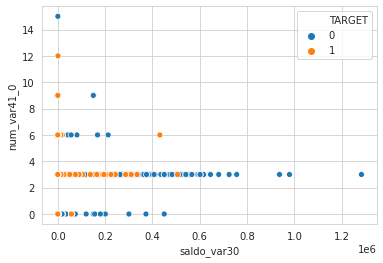

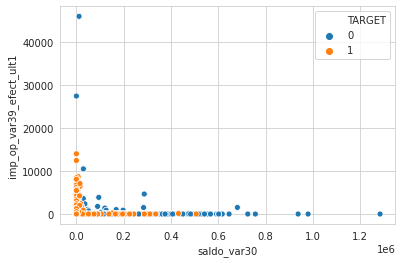

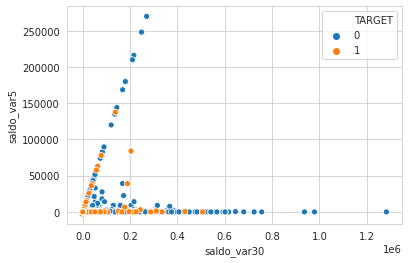

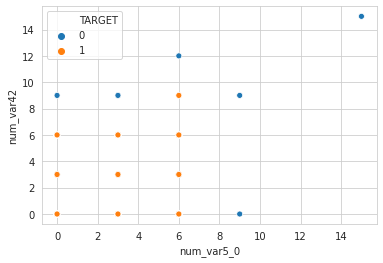

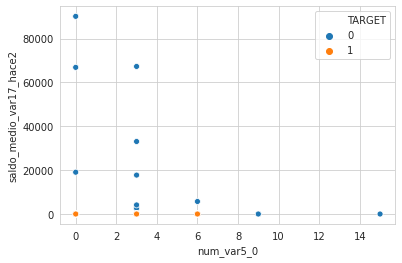

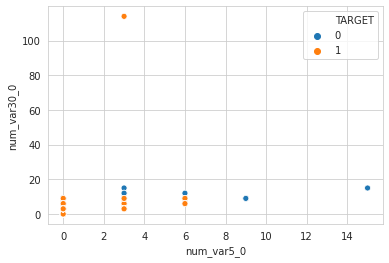

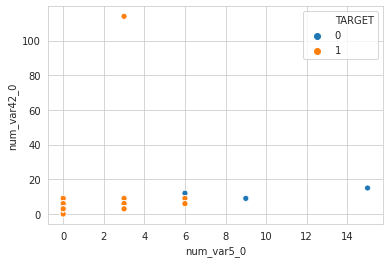

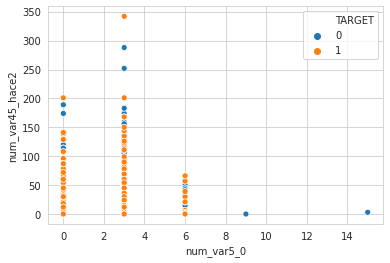

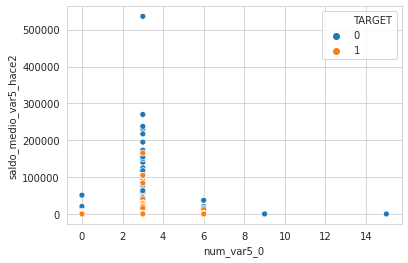

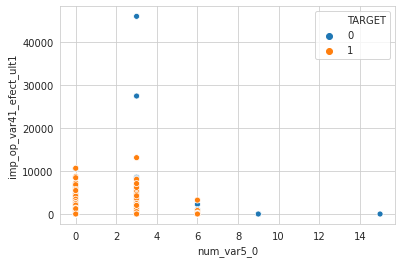

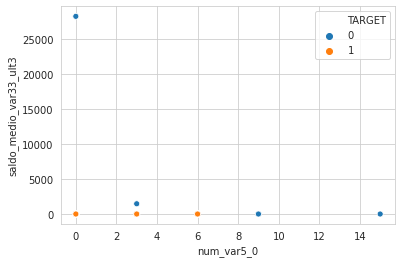

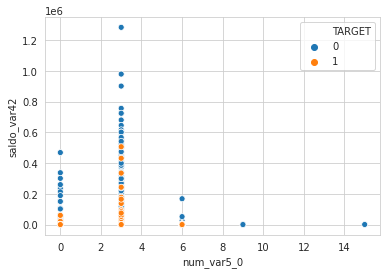

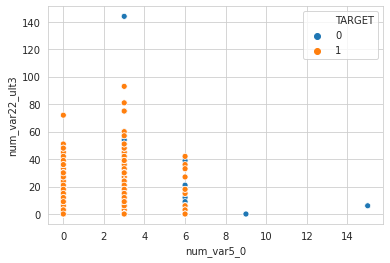

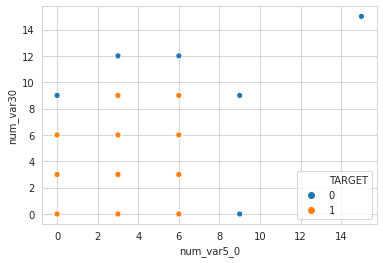

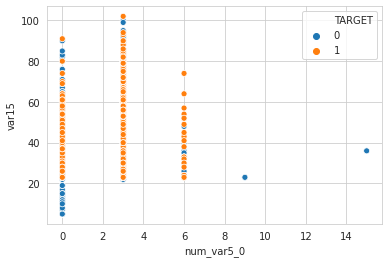

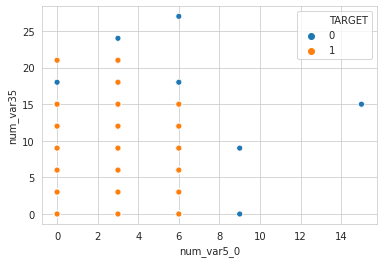

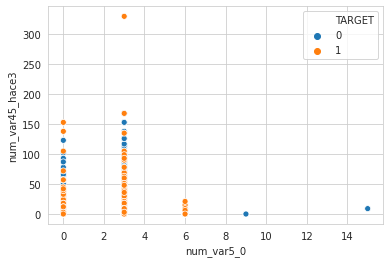

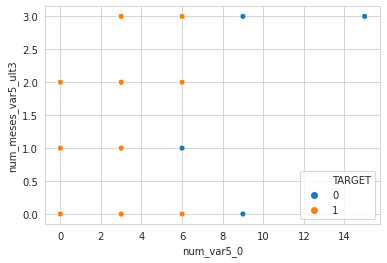

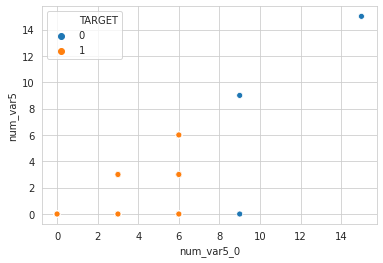

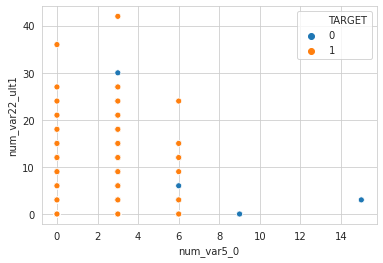

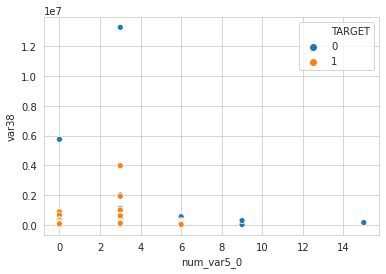

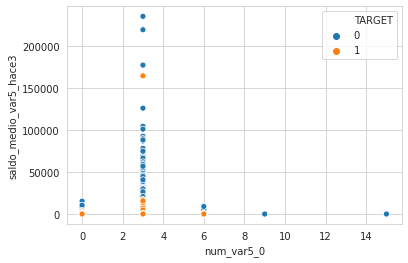

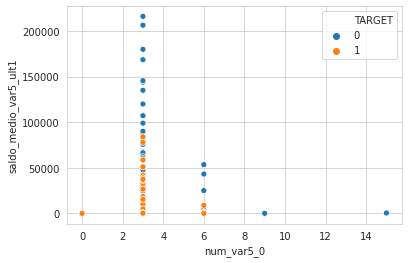

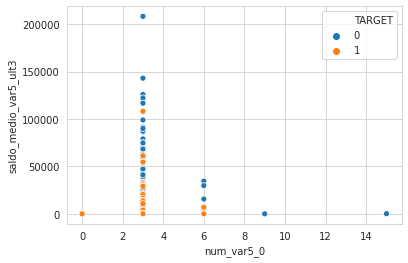

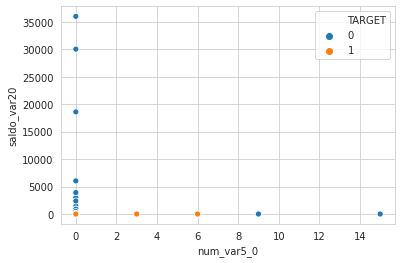

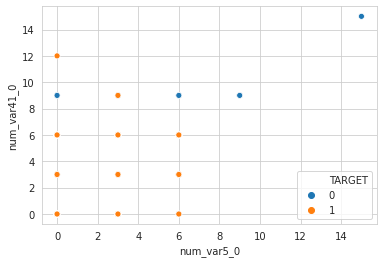

In [77]:
from itertools import combinations

count=1
for i,j in combinations(feature_set,2):
    if(count==50):
      break;

    plt.figure(count)
    sns.scatterplot(x=i,y=j,data=x_down,hue="TARGET")
    count=count+1

**This is how the feature set looks like now. We only have ~10k records.**

In [15]:
x_down=x_down.drop("TARGET",axis=1)
print(x_down.shape)
print(Counter(y_down))

(10528, 27)
Counter({0: 7520, 1: 3008})


In [16]:
def training_and_tuning(model,xtr,ytr,parameters,iterations):
  
  print("started random search cv:\n")
  randomCV = RandomizedSearchCV(model, param_distributions=parameters, n_iter=iterations, cv=10, random_state=7, scoring='roc_auc')
  randomCV.fit(xtr, ytr)
  best = randomCV.best_params_
  best_sc = randomCV.best_score_
  print("best score:")
  print(best_sc)
  print("best parameters obtained:")
  print(best)
  return best

In [17]:
def cv_tuned_model(cl,xtr,ytr):

  cl_roc = cross_val_score(cl, xtr, ytr, cv=10, scoring="roc_auc")
  cl_pred = cross_val_predict(cl, xtr, ytr, cv=10)

  print("auc after 10-fold cv: "+str(cl_roc.mean())+", SD: "+str(cl_roc.std()))

  mat_test = confusion_matrix(ytr,cl_pred,labels=[1,0])
  cl_cm = pd.DataFrame(mat_test, index = [i for i in ["Truth(satisfied)","Truth(unsatisfied)"]],
                    columns = [i for i in ["Predict(satisfied)","Predict(unsatisfied)"]])
  display(cl_cm)

In [18]:
def minmax_scaler(xtr,xte):

  scaler = MinMaxScaler()
  colnames = xtr.columns

  # fitting and transforming train set
  xtr = pd.DataFrame(scaler.fit_transform(xtr))
  xtr.columns = colnames

  # transforming test set
  xte = pd.DataFrame(scaler.transform(xte))
  xte.columns = colnames

  return [xtr,xte]

In [19]:
def kaggle_testset(final_model,trainset,trainlabels,testset,filename):

  final_model.fit(trainset,trainlabels)
  final_predictions = final_model.predict_proba(testset)[:, 1]

  submit = pd.DataFrame(columns=["ID","TARGET"])
  submit["TARGET"] = final_predictions
  submit["ID"] = test["ID"]
  submit.to_csv("/content/drive/My Drive/Colab Notebooks/"+filename,index=False)

**Lets seperate the features of each classifier:**

In [20]:
xtr_lr = x_down[lr_feats]
xtr_rf = x_down[rf_feats]
xtr_gb = x_down[gb_feats]

xte_lr = test[lr_feats]
xte_rf = test[rf_feats]
xte_gb = test[gb_feats]

print("train sets for logistic regression, randomforest, gradientboosting:")
print(xtr_lr.shape)
print(xtr_rf.shape)
print(xtr_gb.shape)

print("test sets for logistic regression, randomforest, gradientboosting:")
print(xte_lr.shape)
print(xte_rf.shape)
print(xte_gb.shape)

train sets for logistic regression, randomforest, gradientboosting:
(10528, 13)
(10528, 12)
(10528, 10)
test sets for logistic regression, randomforest, gradientboosting:
(75818, 13)
(75818, 12)
(75818, 10)


**logistic regression**

In [19]:
xtr_lr,xte_lr = minmax_scaler(xtr_lr,xte_lr)

In [21]:
%%time
parameters = {"C": sp_randint(1, 1000),"class_weight": [None,"balanced"]}
best = training_and_tuning(LogisticRegression(penalty="l1", random_state=7, solver="liblinear"),xtr_lr,y_down,parameters,40)

started random search cv:

best score:
0.7798109117657454
best parameters obtained:
{'C': 896, 'class_weight': 'balanced'}
CPU times: user 4min 21s, sys: 38.6 s, total: 5min
Wall time: 4min 15s


In [22]:
%%time
cl = LogisticRegression(penalty="l1",random_state=7,solver="liblinear",C=best["C"],class_weight=best["class_weight"])
cv_tuned_model(cl, xtr_lr, y_down)

auc after 10-fold cv: 0.7798109117657454, SD: 0.01794054083323058


,Predict(satisfied),Predict(unsatisfied)
Truth(satisfied),2224,784
Truth(unsatisfied),2626,4894


CPU times: user 16.9 s, sys: 1.84 s, total: 18.7 s
Wall time: 16.6 s


In [23]:
# kaggle_testset(cl, xtr_lr, y_down, xte_lr, "lr_after_downsample.csv")

**Kaggle AUC score of 77.69%. Previous score was 77.72% (part 2) however the training time was exponentially more and we were not able to predict the minority class.**

**random forest**

In [21]:
xtr_rf,xte_rf = minmax_scaler(xtr_rf,xte_rf)

In [22]:
%%time
model = RandomForestClassifier(random_state=7,class_weight="balanced")

parameters = {"max_features": list(np.arange(1,12))+[None,"sqrt"],
              "max_depth":list(np.arange(3,30))+[None],
              "n_estimators": np.arange(10,150,5)}

best = training_and_tuning(model,xtr_rf,y_down,parameters,100)

started random search cv:

best score:
0.8384223576553331
best parameters obtained:
{'n_estimators': 70, 'max_features': 5, 'max_depth': 9}
CPU times: user 20min 44s, sys: 638 ms, total: 20min 45s
Wall time: 20min 46s


In [25]:
%%time
cl = RandomForestClassifier(n_estimators=70, max_features=5, max_depth=9, class_weight="balanced", random_state=7)
cv_tuned_model(cl, xtr_rf, y_down)

auc after 10-fold cv: 0.8384223576553331, SD: 0.010290138652475276


,Predict(satisfied),Predict(unsatisfied)
Truth(satisfied),2177,831
Truth(unsatisfied),1483,6037


CPU times: user 16.6 s, sys: 16 ms, total: 16.6 s
Wall time: 16.6 s


In [26]:
# kaggle_testset(cl, xtr_rf, y_down, xte_rf, "rf_after_downsample.csv")

**Kaggle AUC score of 83.15%. Previous score was 82.6% (part 2). Again the training time was exponentially more and we were not able to predict the minority class at all.**

**gradient boost**

In [23]:
xtr_gb,xte_gb = minmax_scaler(xtr_gb,xte_gb)

In [24]:
%%time
model = GradientBoostingClassifier(random_state=7)

parameters = {"max_features": list(np.arange(1,10))+[None,"sqrt"],
              "max_depth":list(np.arange(3,30))+[None],
              "n_estimators": np.arange(10,150,5)}


best = training_and_tuning(model,xtr_gb,y_down,parameters,100)

started random search cv:

best score:
0.843929848201032
best parameters obtained:
{'n_estimators': 60, 'max_features': 3, 'max_depth': 4}
CPU times: user 1h 14min 54s, sys: 568 ms, total: 1h 14min 54s
Wall time: 1h 14min 57s


In [27]:
%%time
cl = GradientBoostingClassifier(n_estimators=60, max_features=3, max_depth=4, random_state=7)
cv_tuned_model(cl, xtr_gb, y_down)

auc after 10-fold cv: 0.843929848201032, SD: 0.008080062040697687


,Predict(satisfied),Predict(unsatisfied)
Truth(satisfied),1747,1261
Truth(unsatisfied),831,6689


CPU times: user 7.02 s, sys: 6 ms, total: 7.02 s
Wall time: 7.03 s


In [28]:
# kaggle_testset(cl, xtr_gb, y_down, xte_gb, "gb_after_downsample.csv")

**Kaggle AUC score of 83.45%. Previous score was 83.19% (part 2). Again the training time was exponentially more and we were not able to predict the minority class at all.**

# So we'll end this problem statement here. We almost reached the kaggle winning score of 84.5% with our best score of 83.19%. Downsampling really helped in this part. Compared to part-2 the the time taken was exponentially less and the kaggle performance was also slightly better. And not to forget we are better able to predict the minority class.